In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sts
import pystan
import seaborn as sns

## Data Loading and PreProcessing

In [ ]:
data = pd.read_csv(
    "http://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv",
    names = ['Date', 'CO2'], )

data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,CO2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


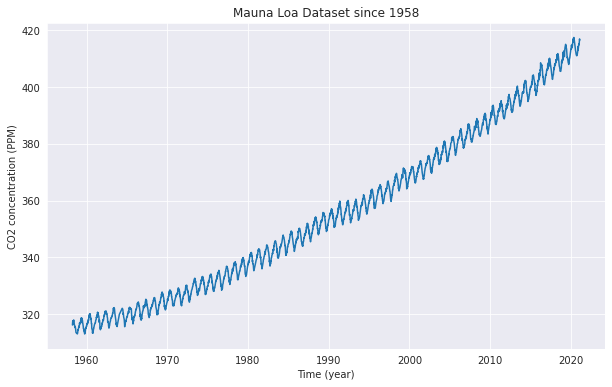

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,6))
sns.lineplot(x='Date', y='CO2', data=data)
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Mauna Loa Dataset since 1958")
plt.show()

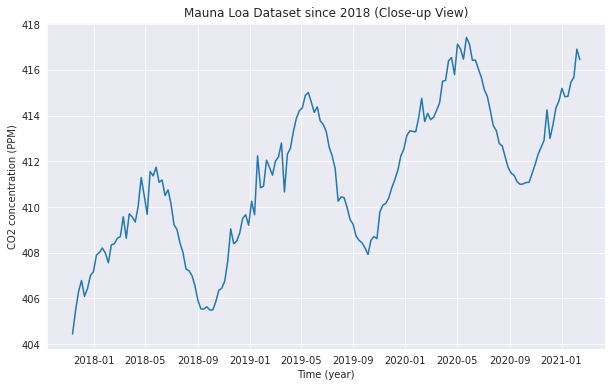

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize = (10,6))
sns.lineplot(x='Date', y='CO2', data=data[-170:])
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Mauna Loa Dataset since 2018 (Close-up View)")
plt.show()

In [ ]:
# changing to year
data['Year'] = (data['Date']- data['Date'][0]).dt.days/365.25
data

,Date,CO2,Year
0,1958-03-29,316.19,0.000000
1,1958-04-05,317.31,0.019165
2,1958-04-12,317.69,0.038330
3,1958-04-19,317.58,0.057495
4,1958-04-26,316.48,0.076660
...,...,...,...
3205,2021-01-16,414.84,62.803559
3206,2021-01-23,415.46,62.822724
3207,2021-01-30,415.68,62.841889
3208,2021-02-06,416.91,62.861054


## Model 1: Linear

$y = N((c_1 + c_2 \cdot x_n + c_3 \cdot \cos(2\pi \cdot x_n + c_4), c_5)$

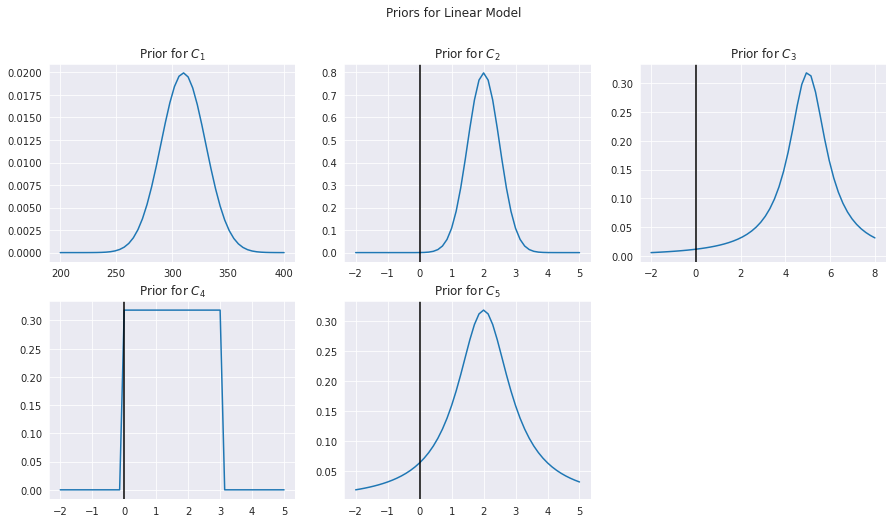

In [ ]:
def truncnorm(mean, sigma, lower = 0):
    '''
    Function to generate a trancated normal distribution with mean = mean 
    and sigma and sigma which will only generate non-negative value
    '''
    myclip_a = lower
    myclip_b = 10**30
    my_mean = mean
    ## if sigma is 0, replace it with a low number to avoid division by 0
    my_std = max(sigma, 10**-30) 

    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return sts.truncnorm(a, b, loc = my_mean, scale = my_std)


#plotting the priors for linear model
fig = plt.figure(figsize=(15,8))
fig.suptitle('Priors for Linear Model')
prior_c1=sts.norm.pdf(np.linspace(200,400),310,20)
prior_c2=truncnorm(2,0.5).pdf(np.linspace(-2,5))
prior_c3=sts.cauchy.pdf(np.linspace(-2,8),loc=5,scale=1)
prior_c4=sts.uniform.pdf(np.linspace(-2,5),0,np.pi)
prior_c5=sts.cauchy.pdf(np.linspace(-2,5),2,1)
plt.subplot(2,3,1)
plt.plot(np.linspace(200,400),prior_c1)
plt.title('Prior for $C_1$')
plt.subplot(2,3,2)
plt.plot(np.linspace(-2,5),prior_c2)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_2$')
plt.subplot(2,3,3)
plt.plot(np.linspace(-2,8),prior_c3)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_3$')
plt.subplot(2,3,4)
plt.plot(np.linspace(-2,5),prior_c4)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_4$')
plt.subplot(2,3,5)
plt.plot(np.linspace(-2,5),prior_c5)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_5$')
plt.show()

In [ ]:
stan_model_linear =  """
data {
  int<lower=0> N;   // number of observations
  real<lower=0> x[N];   // Elapsed year, independent
  real<lower=0> y[N];      // Measured CO2 levels

  real mu_C1;            // Prior mu for C1
  real sd_C1;            //Prior sd for C1

  real mu_C2;            // Prior mu for C2
  real sd_C2;            //Prior sd for C2

  real mu_C3;            // Prior mu for C3
  real sd_C3;            //Prior sd for C3

  real mu_C5;            // Prior mu for C5
  real sd_C5;            //Prior sd for C5

}

parameters {
  real C1;                         // Interception
  real<lower=0> C2;                // Slope
  real<lower=0> C3;                // Magnitude of seasonal variation, lower bound = 0 to mitigate the periodically trend
  real<lower=0,upper=pi()> C4;     // Seasonal variation, lower and upper bound to mitigate periodical trend
  real<lower=0> C5;                // Measurement standard deviation
}

model {

  C1 ~ normal(mu_C1, sd_C1);       //Prior C1
  C2 ~ normal(mu_C2, sd_C2) T[0,];       //Prior C2
  C3 ~ cauchy(mu_C3, sd_C3);       //Prior C3
  C4 ~ uniform(0, pi());           //Prior C4
  C5 ~ cauchy(mu_C5, sd_C5);       //Prior C5

  for (n in 1:N)
    y[n] ~ normal(C1 + C2*x[n]+ C3*cos(2*pi()*x[n] + C4), C5);
}
"""



In [ ]:
model_linear = pystan.StanModel(model_code=stan_model_linear)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_212b0704856d9d139f8f338465f65046 NOW.


In [ ]:
#standata for the linear model
stan_data_linear = {
  "N": len(data),
  "x": data.Year.values,
  "y": data.CO2.values,
  "mu_C1": 310,
  "sd_C1": 20,
  "mu_C2": 2,            
  "sd_C2": 0.5,
  "mu_C3": 5,           
  "sd_C3": 1,           
  "mu_C5": 2,           
  "sd_C5": 1     
}

In [ ]:
linear_results = model_linear.sampling(data = stan_data_linear)

print(linear_results)

Inference for Stan model: anon_model_212b0704856d9d139f8f338465f65046.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C1   305.65  2.6e-3   0.14 305.37 305.55 305.65 305.74 305.93   3008    1.0
C2     1.59  7.0e-5 4.0e-3   1.59   1.59   1.59    1.6    1.6   3176    1.0
C3     2.61  1.7e-3    0.1    2.4   2.54   2.61   2.68    2.8   3755    1.0
C4   3.5e-3  5.7e-5 3.5e-3 7.3e-5 9.7e-4 2.4e-3 4.9e-3   0.01   3835    1.0
C5     4.07  8.5e-4   0.05   3.98   4.04   4.07   4.11   4.18   3763    1.0
lp__  -6122    0.04   1.69  -6126  -6123  -6122  -6121  -6120   1570    1.0

Samples were drawn using NUTS at Tue Apr 27 16:43:19 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
pystan.check_hmc_diagnostics(linear_results)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

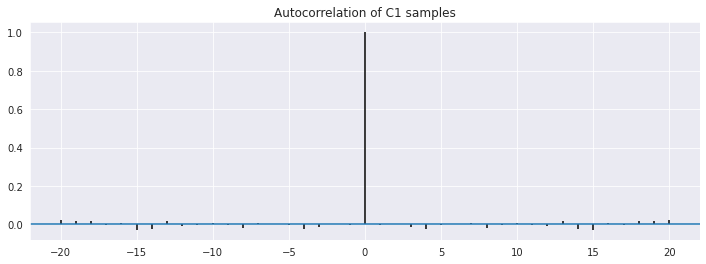

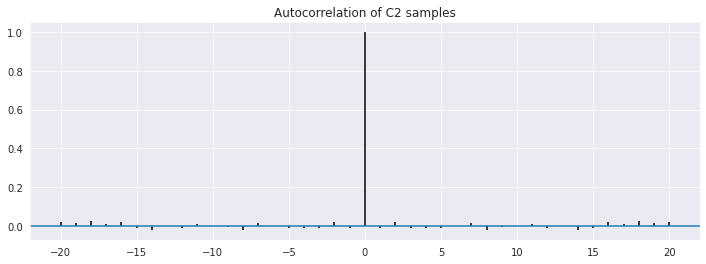

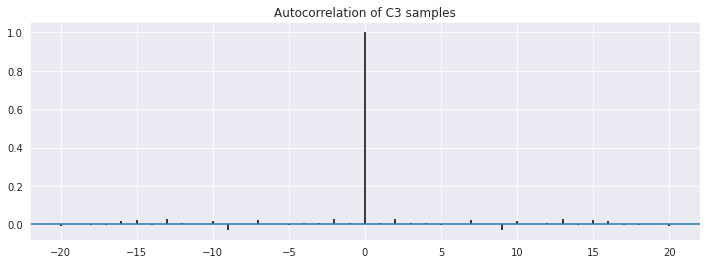

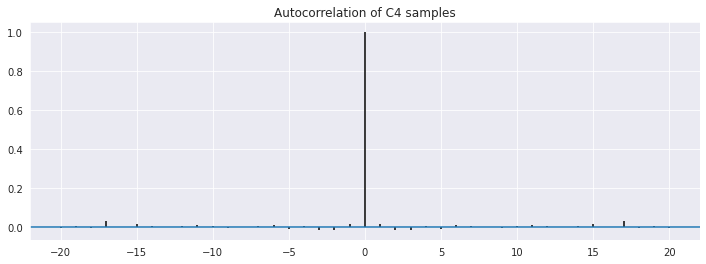

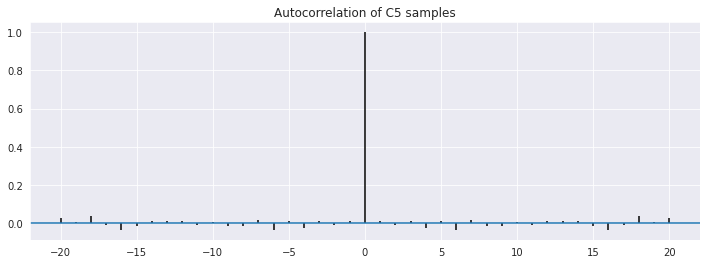

In [ ]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

parameters = ['C1', 'C2', 'C3', 'C4', 'C5']
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(linear_samples[param])
    plt.title(f'Autocorrelation of {param} samples')
plt.show()

<Figure size 2160x2160 with 0 Axes>

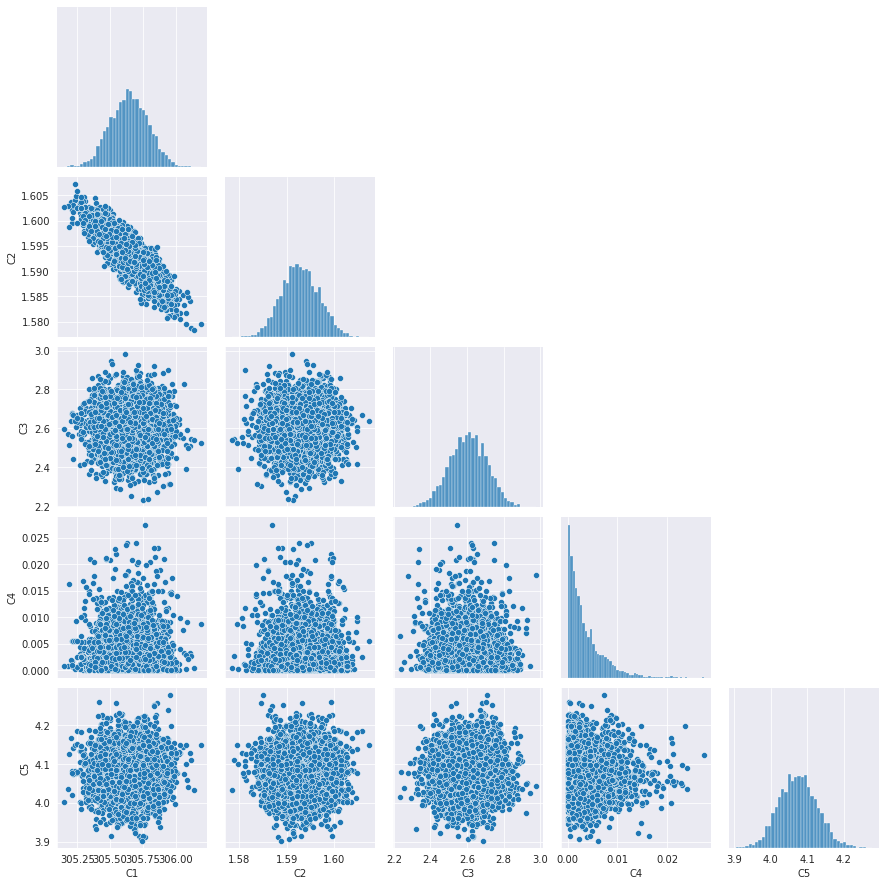

In [ ]:
#Pair plot
#Dataframe for all the parameter samples
parameter_frame = pd.DataFrame(np.transpose([linear_samples[i] for i in parameters]), 
                               columns = parameters)


#Make a pairplot for all the parameters using the sns 
plt.figure(figsize=(30,30))
sns.pairplot(parameter_frame, vars = parameters, 
             dropna = True, corner=True)
plt.show()

In [ ]:
years = data.Year.values
linear_samples = linear_results.extract()

linear_y_pred = np.array([sts.norm.rvs(linear_samples["C1"][i] +            #The interception
                linear_samples["C2"][i] * years +     #The slope
                linear_samples["C3"][i] *             #Seasonal variation
                np.cos(2*np.pi*years + linear_samples["C4"][i]),
                linear_samples["C5"][i])   #noise 
                for i in range(4000)])

In [ ]:
linear_y_pred_mean = linear_y_pred.mean(axis=0)

In [ ]:
linear_y_pred_ci = np.percentile(linear_y_pred, axis = 0, q=[2.5, 97.5])

In [ ]:
linear_y_pred_ci[1].shape

(3210,)

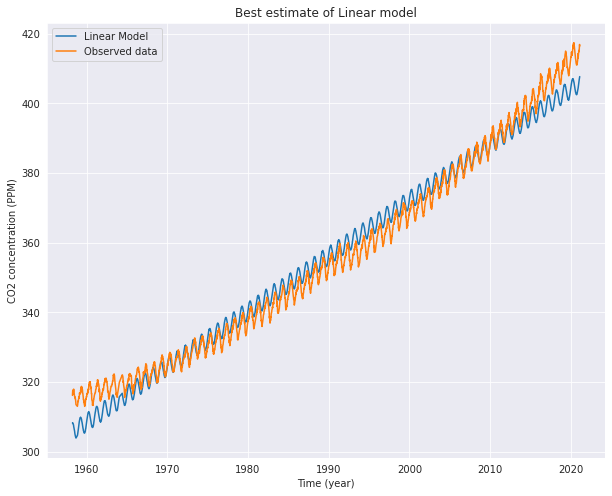

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date, linear_y_pred_mean, label = "Linear Model")
#plt.plot(data.Date, linear_y_pred_ci[0], label = "Lower Confidence Interval")
#plt.plot(data.Date, linear_y_pred_ci[1], label = "Upper confidence Interval")
plt.plot(data.Date, data.CO2, label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate of Linear model")
plt.legend()
plt.show()

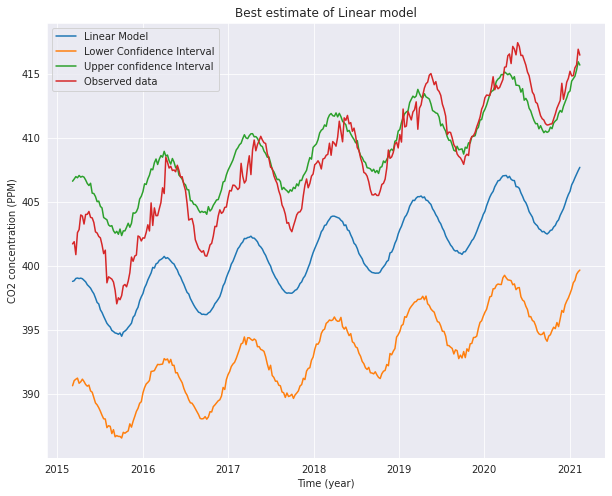

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date[2900:], linear_y_pred_mean[2900:], label = "Linear Model")
plt.plot(data.Date[2900:], linear_y_pred_ci[0][2900:], label = "Lower Confidence Interval")
plt.plot(data.Date[2900:], linear_y_pred_ci[1][2900:], label = "Upper confidence Interval")
plt.plot(data.Date[2900:], data.CO2[2900:], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate of Linear model")
plt.legend()
plt.show()

## Model 2: Quadratic Model

$y = N((c_1 + c_2 \cdot x_n + c_3 \cdot x_n^2 + c_4 \cdot \cos(2\pi \cdot x_n + c_5)), c_6^2)$

In [ ]:
stan_model_quadratic =  """
data {
  int<lower=0> N;   // number of observations
  real<lower=0> x[N];   // Elapsed days, independent
  real<lower=0> y[N];      // Measured CO2 levels

  real mu_C1;            // Prior mu for C1
  real sd_C1;            //Prior sd for C1

  real mu_C2;            // Prior mu for C2
  real sd_C2;            //Prior sd for C2

  real mu_C3;            // Prior mu for C3
  real sd_C3;            //Prior sd for C3

  real mu_C4;            // Prior mu for C4
  real sd_C4;            //Prior sd for C4

  real mu_C6;            //Prior mu for C6
  real sd_C6;            //Prior sd for C6

}

parameters {
  real C1;                         // Interception
  real<lower=0> C2;                // Slope
  real<lower=0> C3;                // Quadratic term
  real<lower=0> C4;                // Magnitude of seasonal variation, lower bound = 0 to mitigate the periodically trend
  real<lower=0,upper=pi()> C5;     // Seasonal variation, lower and upper bound to mitigate periodical trend
  real<lower=0> C6;                // Measurement standard deviation

}

model {

  C1 ~ normal(mu_C1, sd_C1);       //Prior C1
  C2 ~ normal(mu_C2, sd_C2);       //Prior C2
  C3 ~ normal(mu_C3, sd_C3);       //Prior C3
  C4 ~ cauchy(mu_C4, sd_C4);       //Prior seasonal amplitude
  C5 ~ uniform(0, pi());        //Prior for period
  C6 ~ cauchy(mu_C6, sd_C6);       //Prior for sigma

  for (n in 1:N)
    y[n] ~ normal(C1 + C2*x[n] + C3*square(x[n]) + C4*cos(2*pi()*x[n] + C5), C6);
}

"""

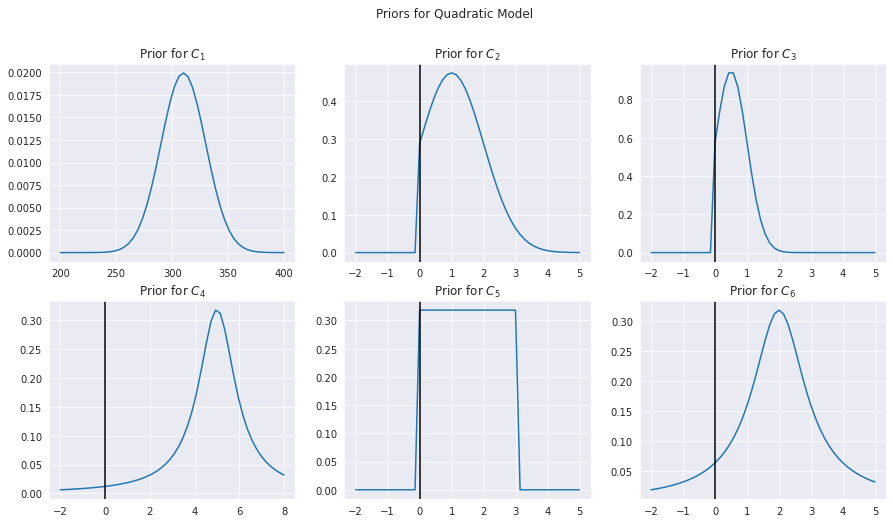

In [ ]:
#plotting the priors quadratic model
fig = plt.figure(figsize=(15,8))
fig.suptitle('Priors for Quadratic Model')
prior_c1=sts.norm.pdf(np.linspace(200,400),310,20)
prior_c2=truncnorm(1,1).pdf(np.linspace(-2,5))
prior_c3=truncnorm(0.5,0.5).pdf(np.linspace(-2,5))
prior_c4=sts.cauchy.pdf(np.linspace(-2,8),5,1)
prior_c5=sts.uniform.pdf(np.linspace(-2,5),0,np.pi)
prior_c6=sts.cauchy.pdf(np.linspace(-2,5),2,1)
plt.subplot(2,3,1)
plt.plot(np.linspace(200,400),prior_c1)
plt.title('Prior for $C_1$')
plt.subplot(2,3,2)
plt.plot(np.linspace(-2,5),prior_c2)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_2$')
plt.subplot(2,3,3)
plt.plot(np.linspace(-2,5),prior_c3)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_3$')
plt.subplot(2,3,4)
plt.plot(np.linspace(-2,8),prior_c4)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_4$')
plt.subplot(2,3,5)
plt.plot(np.linspace(-2,5),prior_c5)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_5$')
plt.subplot(2,3,6)
plt.plot(np.linspace(-2,5),prior_c6)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_6$')
plt.show()

In [ ]:
model_quadratic = pystan.StanModel(model_code=stan_model_quadratic)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_da6c7dab813d41592c9a90dd8b82c156 NOW.


In [ ]:

#standata for the quadratic model
stan_data_quadratic = {
  "N": len(data),
  "x": data.Year.values,
  "y": data.CO2.values,
  "mu_C1": 310,
  "sd_C1": 20,
  "mu_C2": 1,            
  "sd_C2": 1,
  "mu_C3": 0.5,           
  "sd_C3": 0.5,           
  "mu_C4": 5,           
  "sd_C4": 1,
  "mu_C6": 2,           
  "sd_C6": 1
}


In [ ]:
quad_results = model_quadratic.sampling(data = stan_data_quadratic)

print(quad_results)

Inference for Stan model: anon_model_da6c7dab813d41592c9a90dd8b82c156.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C1   314.72  1.8e-3   0.07 314.58 314.67 314.72 314.77 314.86   1504    1.0
C2     0.75  1.3e-4 5.1e-3   0.74   0.75   0.75   0.75   0.76   1435    1.0
C3     0.01  1.9e-6 7.7e-5   0.01   0.01   0.01   0.01   0.01   1578    1.0
C4     2.62  6.2e-4   0.03   2.56    2.6   2.62   2.64   2.68   2674    1.0
C5   3.4e-4  6.1e-6 3.4e-4 6.5e-6 9.4e-5 2.4e-4 4.6e-4 1.3e-3   3179    1.0
C6     1.27  3.1e-4   0.02   1.24   1.26   1.27   1.29   1.31   2647    1.0
lp__  -2397    0.05   1.82  -2401  -2398  -2397  -2396  -2394   1213    1.0

Samples were drawn using NUTS at Tue Apr 27 18:10:00 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
co

In [ ]:
pystan.check_hmc_diagnostics(quad_results)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': True}

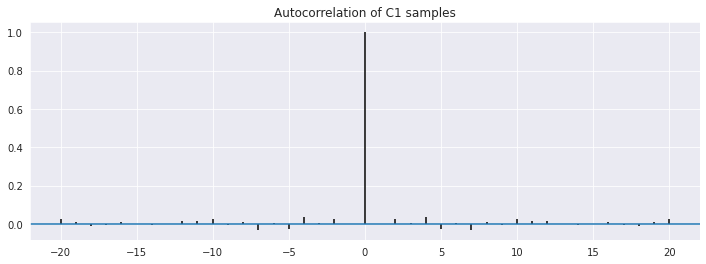

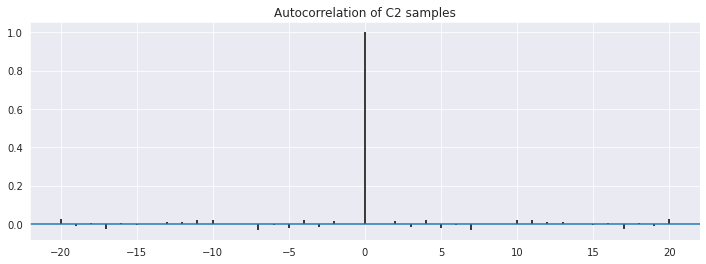

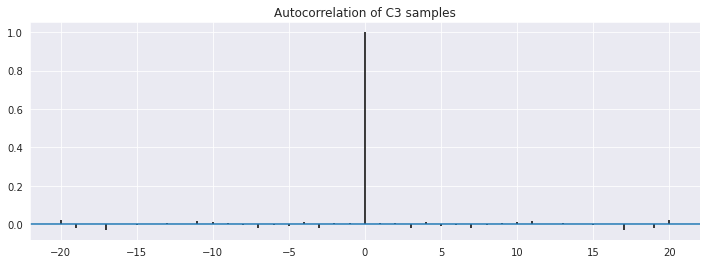

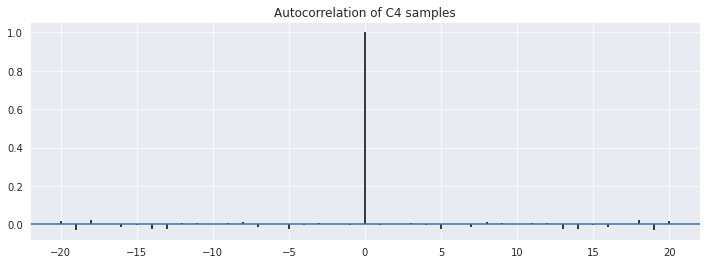

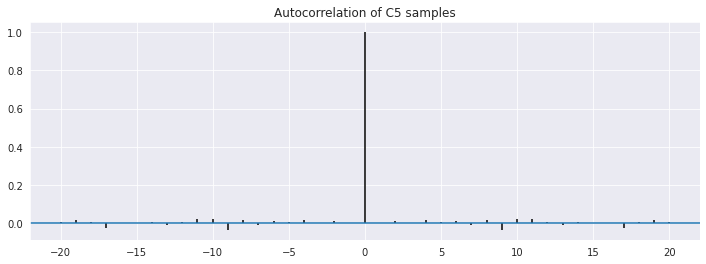

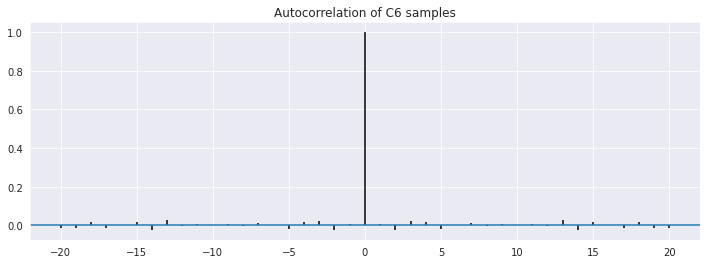

In [ ]:
parameters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(quad_samples[param])
    plt.title(f'Autocorrelation of {param} samples')
plt.show()

<Figure size 2160x2160 with 0 Axes>

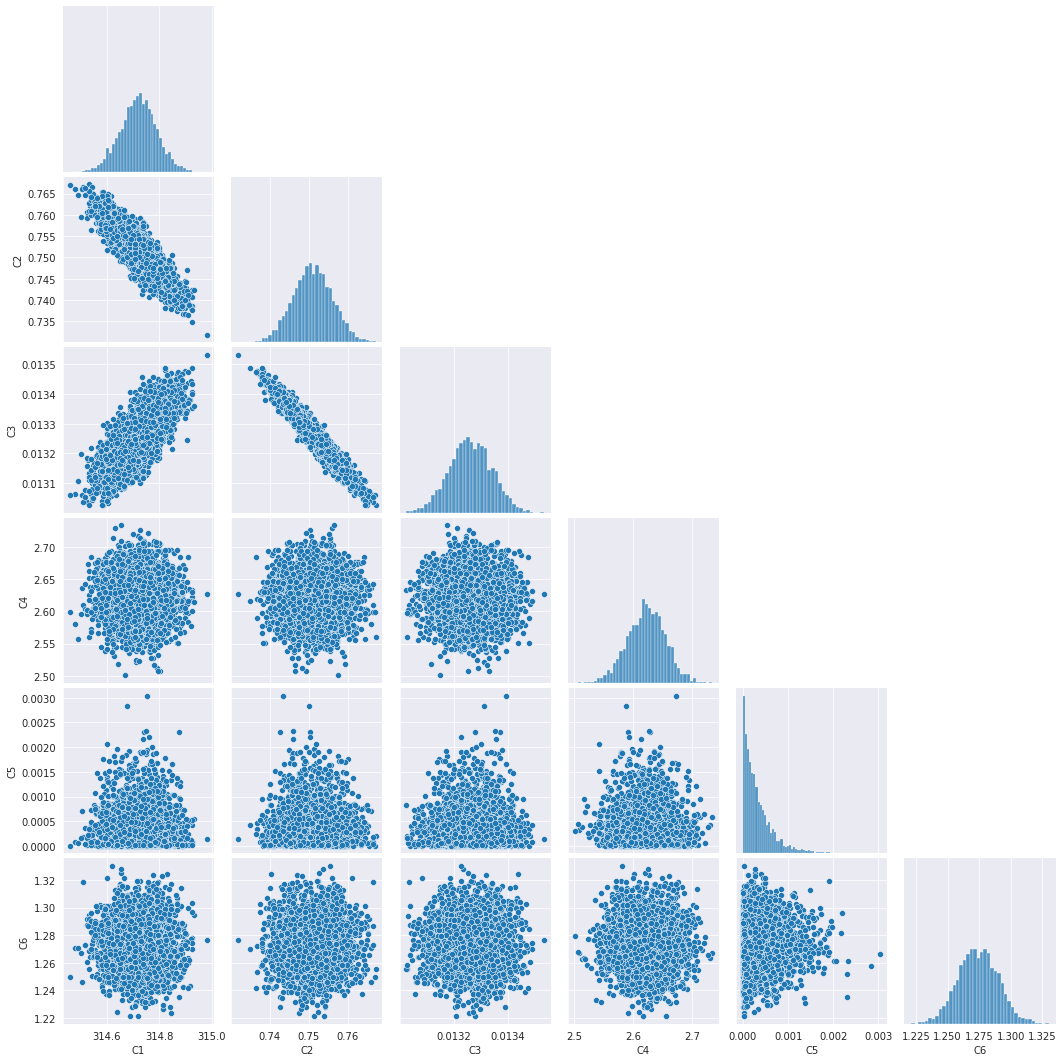

In [ ]:
#Pair plot
#Dataframe for all the parameter samples
parameter_frame = pd.DataFrame(np.transpose([quad_samples[i] for i in parameters]), 
                               columns = parameters)


#Make a pairplot for all the parameters using the sns 
plt.figure(figsize=(30,30))
sns.pairplot(parameter_frame, vars = parameters, 
             dropna = True, corner=True)
plt.show()

In [ ]:
years = data.Year.values
quad_samples = quad_results.extract()

quad_y_pred = np.array([sts.norm.rvs(quad_samples["C1"][i] +            #The interception
                quad_samples["C2"][i] * years +         #The slope
                quad_samples["C3"][i] * years**2 +      #The second order coefficient 
                quad_samples["C4"][i] *                 #Seasonal variation
                np.cos(2*np.pi*years + quad_samples["C5"][i]),
                quad_samples["C6"][i])   #noise 
                for i in range(4000)])

In [ ]:
quad_y_pred_mean = quad_y_pred.mean(axis=0)
quad_y_pred_ci = np.percentile(quad_y_pred, axis = 0, q=[2.5, 97.5])

In [ ]:
quad_y_pred_ci[1].shape

(3210,)

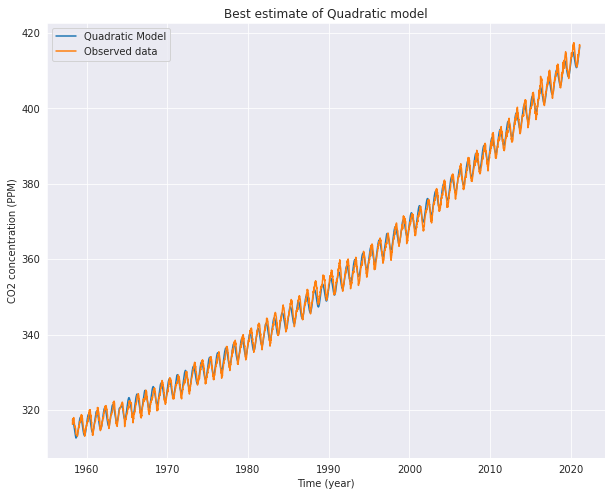

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date, quad_y_pred_mean, label = "Quadratic Model")
#plt.plot(data.Date, quad_y_pred_ci[0], label = "Lower Confidence Interval")
#plt.plot(data.Date, quad_y_pred_ci[1], label = "Upper confidence Interval")
plt.plot(data.Date, data.CO2, label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate of Quadratic model")
plt.legend()
plt.show()

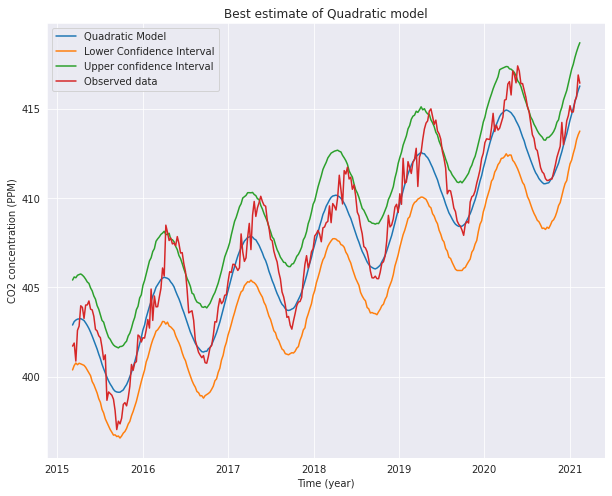

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date[2900:], quad_y_pred_mean[2900:], label = "Quadratic Model")
plt.plot(data.Date[2900:], quad_y_pred_ci[0][2900:], label = "Lower Confidence Interval")
plt.plot(data.Date[2900:], quad_y_pred_ci[1][2900:], label = "Upper confidence Interval")
plt.plot(data.Date[2900:], data.CO2[2900:], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate of Quadratic model")
plt.legend()
plt.show()

## Model 3: Cubic

$y = N((c_1 + c_2 \cdot x_n + c_3 \cdot x_n^2 + c_4 \cdot x_n^3 + c_5 \cdot \sin(2\pi \cdot x_n + c_6)), c_7^2)$

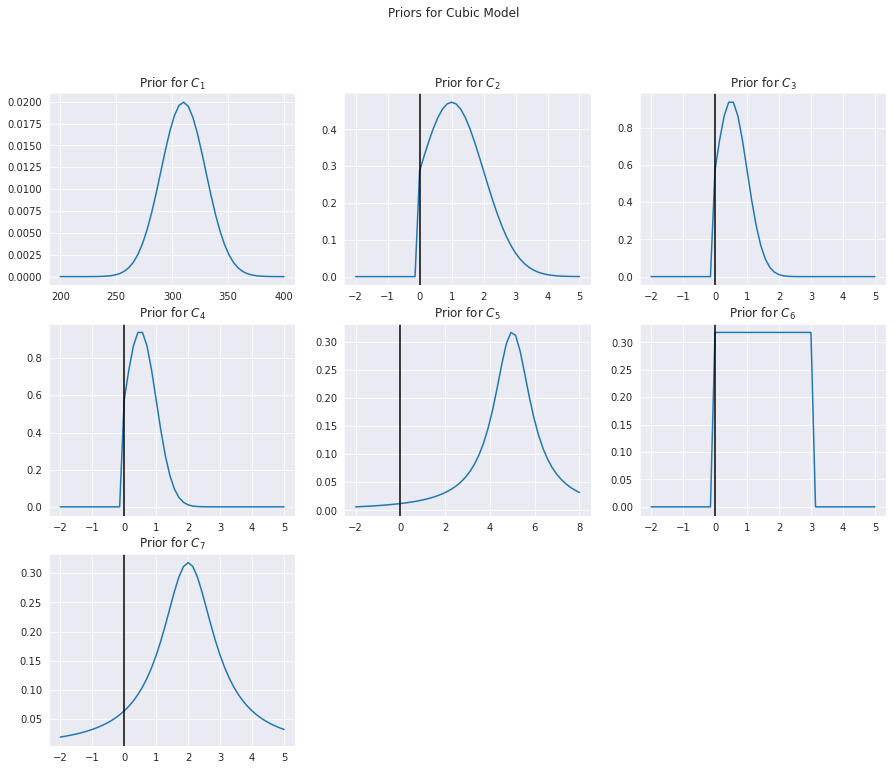

In [ ]:
#plotting the priors quadratic model
fig = plt.figure(figsize=(15,12))
fig.suptitle('Priors for Cubic Model')
prior_c1=sts.norm.pdf(np.linspace(200,400),310,20)
prior_c2=truncnorm(1,1).pdf(np.linspace(-2,5))
prior_c3=truncnorm(0.5,0.5).pdf(np.linspace(-2,5))
prior_c4=truncnorm(0.5,0.5).pdf(np.linspace(-2,5))
prior_c5=sts.cauchy.pdf(np.linspace(-2,8),5,1)
prior_c6=sts.uniform.pdf(np.linspace(-2,5),0,np.pi)
prior_c7=sts.cauchy.pdf(np.linspace(-2,5),2,1)
plt.subplot(3,3,1)
plt.plot(np.linspace(200,400),prior_c1)
plt.title('Prior for $C_1$')
plt.subplot(3,3,2)
plt.plot(np.linspace(-2,5),prior_c2)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_2$')
plt.subplot(3,3,3)
plt.plot(np.linspace(-2,5),prior_c3)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_3$')
plt.subplot(3,3,4)
plt.plot(np.linspace(-2,5),prior_c4)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_4$')
plt.subplot(3,3,5)
plt.plot(np.linspace(-2,8),prior_c5)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_5$')
plt.subplot(3,3,6)
plt.plot(np.linspace(-2,5),prior_c6)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_6$')
plt.subplot(3,3,7)
plt.plot(np.linspace(-2,5),prior_c7)
plt.axvline(x=0,color='black')
plt.title('Prior for $C_7$')
plt.show()

In [ ]:
stan_model_cubic =  """
data {
  int<lower=0> N;   // number of observations
  real<lower=0> x[N];   // Elapsed days, independent
  real<lower=0> y[N];      // Measured CO2 levels

  real mu_C1;            // Prior mu for C1
  real sd_C1;            //Prior sd for C1

  real mu_C2;            // Prior mu for C2
  real sd_C2;            //Prior sd for C2

  real mu_C3;            // Prior mu for C3
  real sd_C3;            //Prior sd for C3

  real mu_C4;            // Prior mu for C4
  real sd_C4;            //Prior sd for C4

  real mu_C5;            // Prior mu for C5
  real sd_C5;            //Prior sd for C5

  real mu_C7;            //Prior mu for C7
  real sd_C7;            //Prior sd for C7

}

parameters {
  real C1;                         // Interception
  real<lower=0> C2;                // Slope
  real<lower=0> C3;                // Quadratic term Coefficient
  real<lower=0> C4;                // Cubic term Coefficient
  real<lower=0> C5;                // Magnitude of seasonal variation, lower bound = 0 to mitigate the periodically trend
  real<lower=0,upper=pi()> C6;     // Seasonal variation, lower and upper bound to mitigate periodical trend
  real<lower=0> C7;                // Measurement standard deviation

}

model {

  C1 ~ normal(mu_C1, sd_C1);       //Prior C1
  C2 ~ normal(mu_C2, sd_C2);       //Prior C2
  C3 ~ normal(mu_C3, sd_C3);       //Prior C3
  C4 ~ normal(mu_C4, sd_C4);       //Prior C4
  C5 ~ cauchy(mu_C5, sd_C5);       //Prior seasonal amplitude
  C6 ~ uniform(0, pi());           //Prior for period
  C7 ~ cauchy(mu_C7, sd_C7);       //Prior for sigma

  for (n in 1:N)
    y[n] ~ normal(C1 + C2*x[n] + C3*square(x[n]) + C4*pow(x[n], 3) + C5*sin(2*pi()*x[n] + C6), C7);
}

"""

In [ ]:
model_cubic = pystan.StanModel(model_code=stan_model_cubic)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8c0edc5765cb21a1feb115413a77e0c NOW.


In [ ]:

#standata for the cubic model
stan_data_cubic = {
  "N": len(data),
  "x": data.Year.values,
  "y": data.CO2.values,
  "mu_C1": 310,
  "sd_C1": 20,
  "mu_C2": 1,            
  "sd_C2": 1,
  "mu_C3": 0.5,           
  "sd_C3": 0.5, 
  "mu_C4": 0.5,           
  "sd_C4": 0.5,           
  "mu_C5": 5,           
  "sd_C5": 1,
  "mu_C7": 2,           
  "sd_C7": 1
}


In [ ]:
%%time
cubic_results = model_cubic.sampling(data = stan_data_cubic)

In [ ]:
print(cubic_results)

Inference for Stan model: anon_model_c8c0edc5765cb21a1feb115413a77e0c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C1   314.14  1.8e-3   0.07  314.0 314.09 314.14 314.19 314.29   1569    1.0
C2     0.86  2.8e-4 9.9e-3   0.84   0.85   0.86   0.86   0.88   1273    1.0
C3   9.1e-3  1.0e-5 3.6e-4 8.4e-3 8.9e-3 9.1e-3 9.3e-3 9.8e-3   1301    1.0
C4   4.4e-5  1.0e-7 3.7e-6 3.6e-5 4.1e-5 4.4e-5 4.6e-5 5.1e-5   1377    1.0
C5     2.86  4.4e-4   0.02   2.82   2.85   2.86   2.88   2.91   2820    1.0
C6     1.16  1.6e-4 8.5e-3   1.14   1.15   1.16   1.16   1.18   2885    1.0
C7     0.96  2.4e-4   0.01   0.94   0.95   0.96   0.97   0.99   2506    1.0
lp__  -1498    0.05   1.92  -1502  -1499  -1497  -1496  -1495   1486    1.0

Samples were drawn using NUTS at Tue Apr 27 20:14:07 2021.
For each parameter, n_eff is a crude measure of effective sample si

In [ ]:
pystan.check_hmc_diagnostics(cubic_results)

{'Rhat': True,
 'divergence': True,
 'energy': True,
 'n_eff': True,
 'treedepth': False}

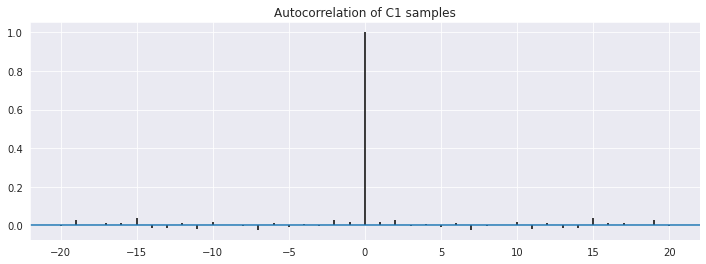

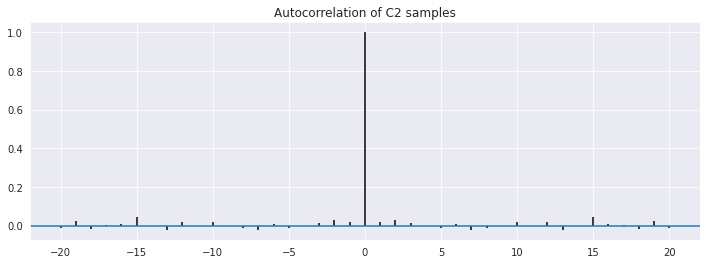

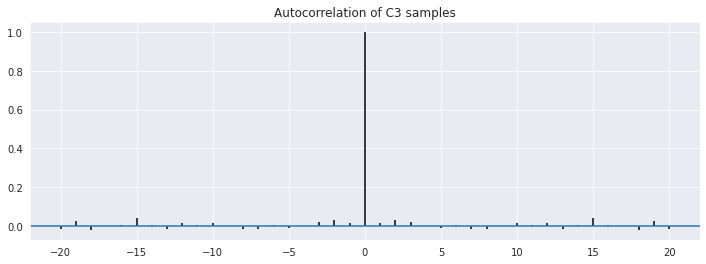

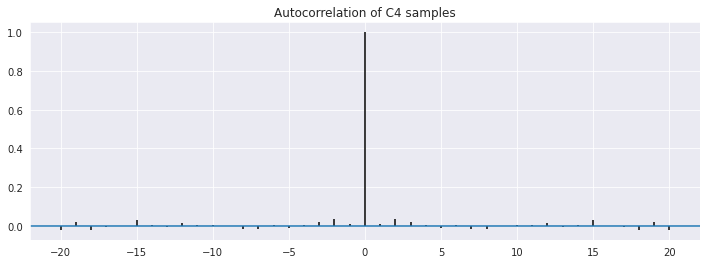

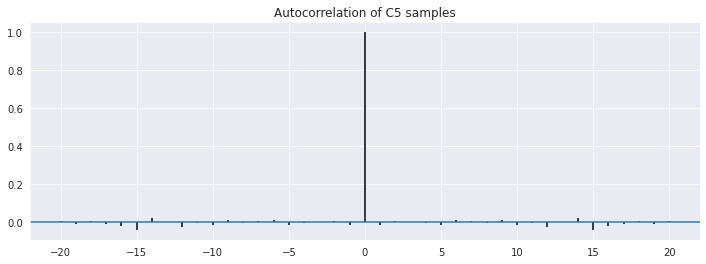

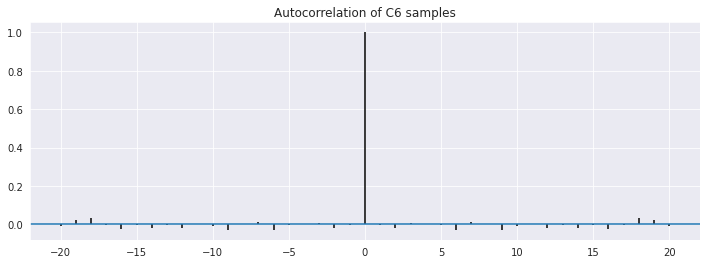

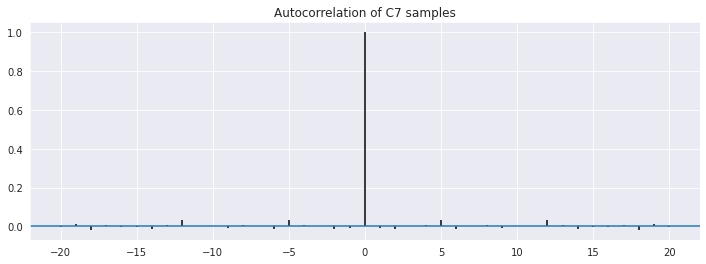

In [ ]:
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

parameters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(cubic_samples[param])
    plt.title(f'Autocorrelation of {param} samples')
plt.show()

<Figure size 2160x2160 with 0 Axes>

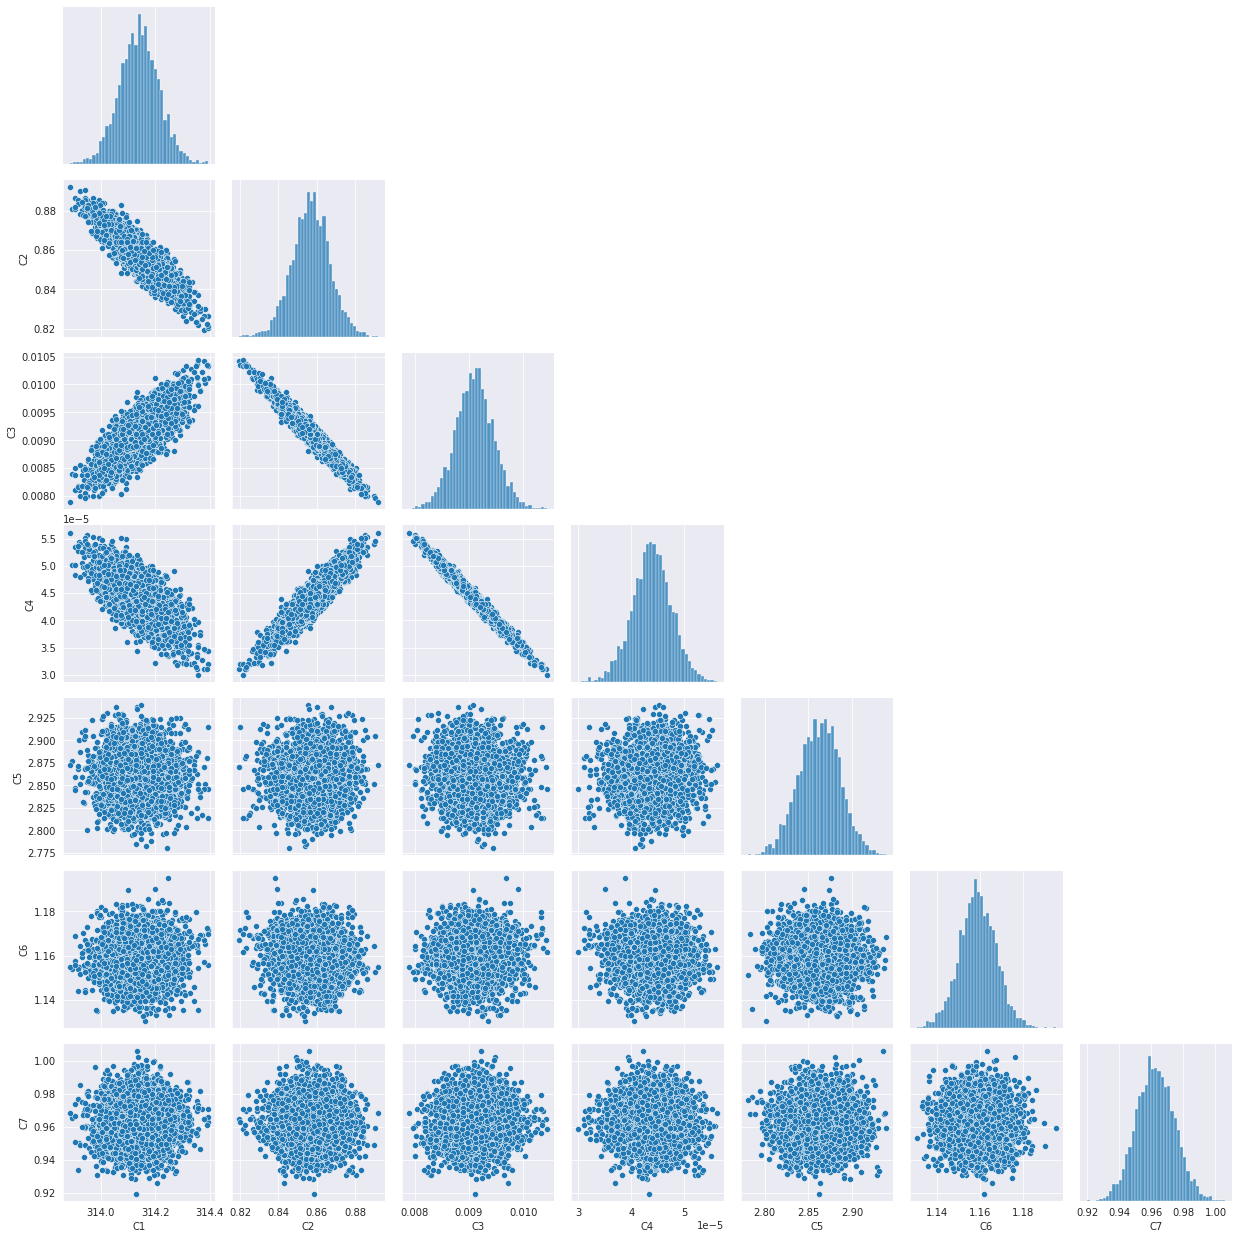

In [ ]:
#Pair plot
#Dataframe for all the parameter samples
parameter_frame = pd.DataFrame(np.transpose([cubic_samples[i] for i in parameters]), 
                               columns = parameters)


#Make a pairplot for all the parameters using the sns 
plt.figure(figsize=(30,30))
sns.pairplot(parameter_frame, vars = parameters, 
             dropna = True, corner=True)
plt.show()

In [ ]:
years = data.Year.values
cubic_samples = cubic_results.extract()

cubic_y_pred = np.array([sts.norm.rvs(cubic_samples["C1"][i] +            #The interception
                cubic_samples["C2"][i] * years +         #The slope
                cubic_samples["C3"][i] * years**2 +   #The second order coefficient 
                cubic_samples["C4"][i] * years**3 +   #The third order coefficient 
                cubic_samples["C5"][i] *                 #Seasonal variation
                np.cos(2*np.pi*years + cubic_samples["C6"][i]),
                cubic_samples["C7"][i])   #noise 
                for i in range(4000)])

In [ ]:
cubic_y_pred_mean = cubic_y_pred.mean(axis=0)
cubic_y_pred_ci = np.percentile(cubic_y_pred, axis = 0, q=[2.5, 97.5])

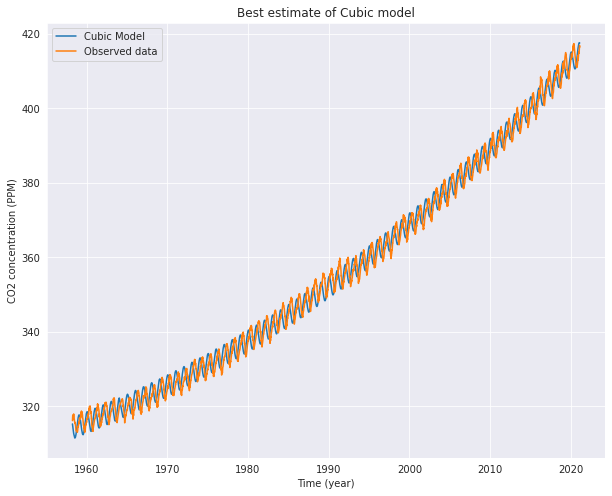

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date, cubic_y_pred_mean, label = "Cubic Model")
#plt.plot(data.Date, quad_y_pred_ci[0], label = "Lower Confidence Interval")
#plt.plot(data.Date, quad_y_pred_ci[1], label = "Upper confidence Interval")
plt.plot(data.Date, data.CO2, label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate of Cubic model")
plt.legend()
plt.show()

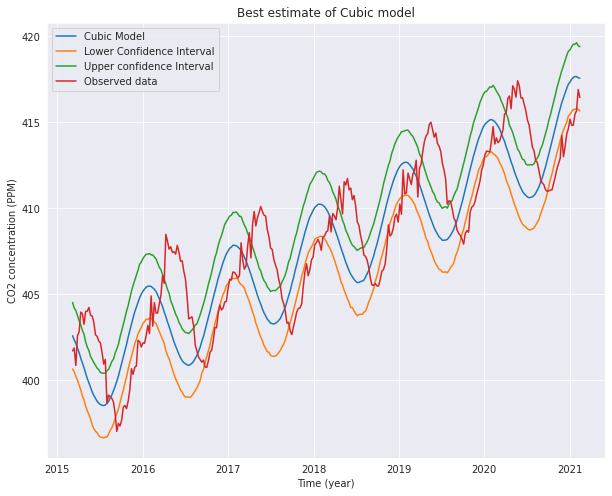

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date[2900:], cubic_y_pred_mean[2900:], label = "Cubic Model")
plt.plot(data.Date[2900:], cubic_y_pred_ci[0][2900:], label = "Lower Confidence Interval")
plt.plot(data.Date[2900:], cubic_y_pred_ci[1][2900:], label = "Upper confidence Interval")
plt.plot(data.Date[2900:], data.CO2[2900:], label = "Observed data")
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best estimate of Cubic model")
plt.legend()
plt.show()

In [ ]:
MSE_linear = np.mean([np.mean(np.square(np.transpose(linear_y_pred[i])-data.CO2.values)) for i in range(4000)])
MSE_quad = np.mean([np.mean(np.square(np.transpose(quad_y_pred[i])-data.CO2.values)) for i in range(4000)])
MSE_cubic = np.mean([np.mean(np.square(np.transpose(cubic_y_pred[i])-data.CO2.values)) for i in range(4000)])

MSE_linear, MSE_quad, MSE_cubic

(33.19912794441372, 3.247031882602752, 10.087887341349845)

## Inference and Prediction

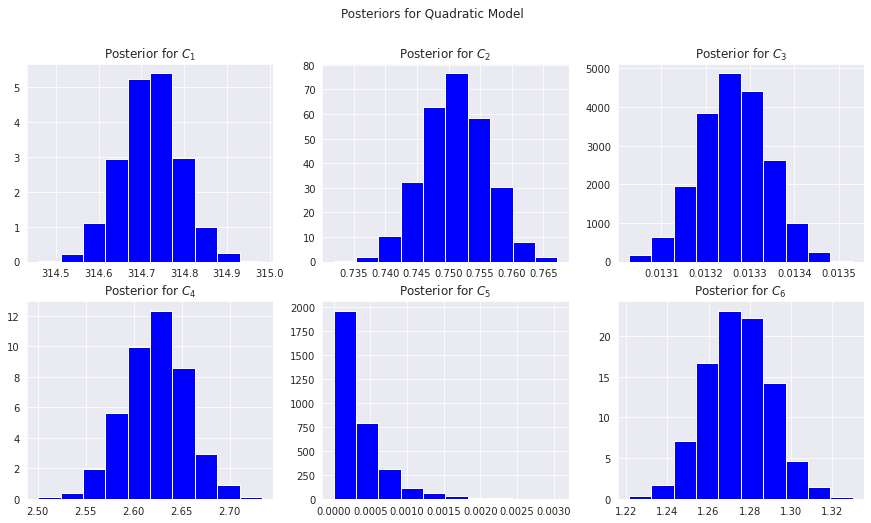

In [ ]:
#plotting the Posteriors quadratic model
fig = plt.figure(figsize=(15,8))
fig.suptitle('Posteriors for Quadratic Model')
prior_c1=sts.norm.pdf(np.linspace(200,400),310,20)
prior_c2=truncnorm(1,1).pdf(np.linspace(-2,5))
prior_c3=truncnorm(0.5,0.5).pdf(np.linspace(-2,5))
prior_c4=sts.cauchy.pdf(np.linspace(-2,8),5,1)
prior_c5=sts.uniform.pdf(np.linspace(-2,5),0,np.pi)
prior_c6=sts.cauchy.pdf(np.linspace(-2,5),2,1)
plt.subplot(2,3,1)
#plt.plot(np.linspace(200,400),prior_c1)
plt.hist(quad_samples['C1'], density = True, color = 'blue')
plt.title('Posterior for $C_1$')
plt.subplot(2,3,2)
#plt.plot(np.linspace(-2,5),prior_c2)
plt.hist(quad_samples['C2'], density = True, color = 'blue')
#plt.axvline(x=0,color='black')
plt.title('Posterior for $C_2$')
plt.subplot(2,3,3)
#plt.plot(np.linspace(-2,5),prior_c3)
plt.hist(quad_samples['C3'], density = True, color = 'blue')
#plt.axvline(x=0,color='black')
plt.title('Posterior for $C_3$')
plt.subplot(2,3,4)
#plt.plot(np.linspace(-2,8),prior_c4)
plt.hist(quad_samples['C4'], density = True, color = 'blue')
#plt.axvline(x=0,color='black')
plt.title('Posterior for $C_4$')
plt.subplot(2,3,5)
#plt.plot(np.linspace(-2,5),prior_c5)
plt.hist(quad_samples['C5'], density = True, color = 'blue')
#plt.axvline(x=0,color='black')
plt.title('Posterior for $C_5$')
plt.subplot(2,3,6)
#plt.plot(np.linspace(-2,5),prior_c6)
plt.hist(quad_samples['C6'], density = True, color = 'blue')
#plt.axvline(x=0,color='black')
plt.title('Posterior for $C_6$')
plt.show()

In [ ]:
# define the dates for which we want to predict
last_date = pd.to_datetime('20600101')
future_days = pd.date_range(data.Date.values[-1], last_date, freq='7d').to_series()

future_days

2021-02-13   2021-02-13
2021-02-20   2021-02-20
2021-02-27   2021-02-27
2021-03-06   2021-03-06
2021-03-13   2021-03-13
                ...    
2059-11-29   2059-11-29
2059-12-06   2059-12-06
2059-12-13   2059-12-13
2059-12-20   2059-12-20
2059-12-27   2059-12-27
Freq: 7D, Length: 2029, dtype: datetime64[ns]

In [ ]:
future_years = (future_days - data.Date[0]).dt.days/365.25

quad_y_pred_future = np.array([sts.norm.rvs(quad_samples["C1"][i] +            #The interception
                quad_samples["C2"][i] * future_years +         #The slope
                quad_samples["C3"][i] * future_years**2 +      #The second order coefficient 
                quad_samples["C4"][i] *                 #Seasonal variation
                np.cos(2*np.pi*future_years + quad_samples["C5"][i]),
                quad_samples["C6"][i])   #noise 
                for i in range(4000)])

In [ ]:
quad_y_pred_future_mean = quad_y_pred_future.mean(axis=0)
quad_y_pred_future_ci = np.percentile(quad_y_pred_future, axis = 0, q=[2.5, 97.5])

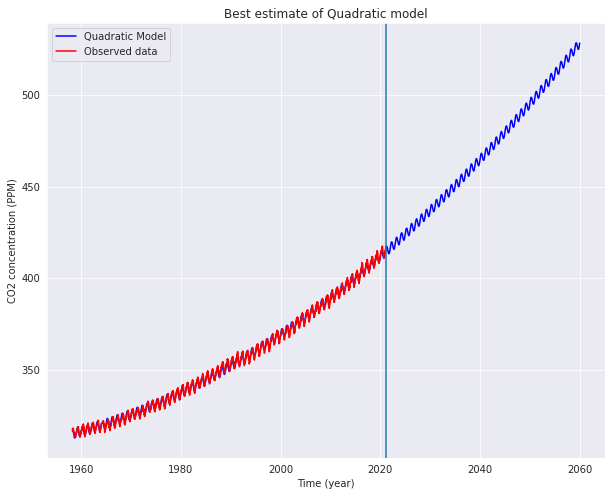

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date, quad_y_pred_mean, label = "Quadratic Model", color = 'blue')
plt.plot(future_days, quad_y_pred_future_mean, color = 'blue')
#plt.plot(data.Date, quad_y_pred_ci[0], label = "Lower Confidence Interval")
#plt.plot(data.Date, quad_y_pred_ci[1], label = "Upper confidence Interval")
plt.plot(data.Date, data.CO2, label = "Observed data", color='red')
plt.axvline(data.Date.values[-1])
plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best Estimate using Quadratic model")
plt.legend()
plt.show()

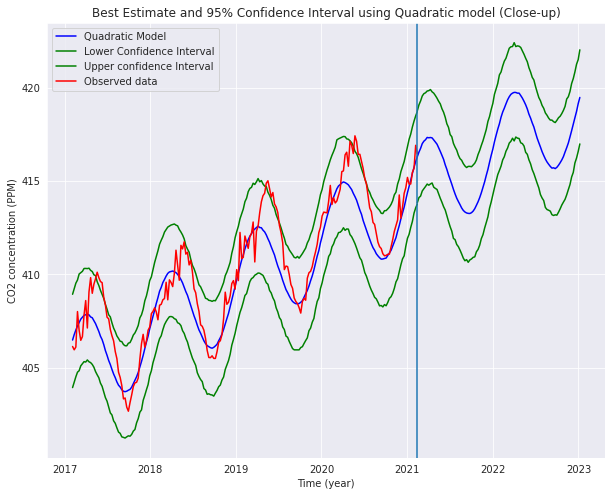

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(data.Date[3000:], quad_y_pred_mean[3000:], label = "Quadratic Model", color = 'blue')
plt.plot(data.Date[3000:], quad_y_pred_ci[0][3000:], label = "Lower Confidence Interval", color = 'green')
plt.plot(data.Date[3000:], quad_y_pred_ci[1][3000:], label = "Upper confidence Interval", color = 'green')
plt.plot(data.Date[3000:], data.CO2[3000:], label = "Observed data", color = 'red')
plt.plot(future_days[:100], quad_y_pred_future_mean[:100], color = 'blue')
plt.plot(future_days[:100], quad_y_pred_future_ci[0][:100], color = 'green')
plt.plot(future_days[:100], quad_y_pred_future_ci[1][:100], color = 'green')
plt.axvline(data.Date.values[-1])

plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best Estimate and 95% Confidence Interval using Quadratic model (Close-up)")
plt.legend()
plt.show()

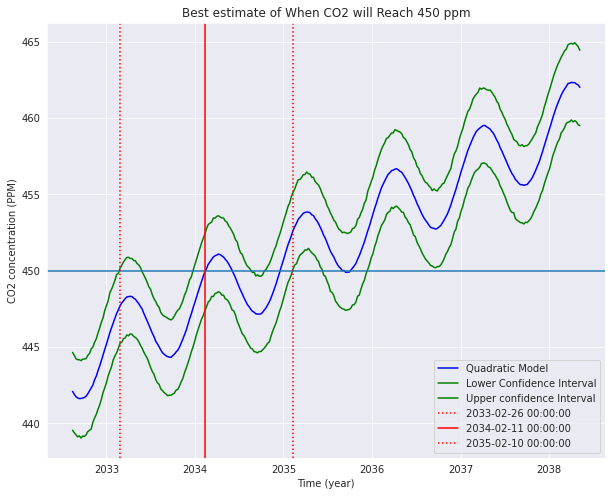

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(future_days[600:900], quad_y_pred_future_mean[600:900], label = "Quadratic Model", color = 'blue')
plt.plot(future_days[600:900], quad_y_pred_future_ci[0][600:900], label = "Lower Confidence Interval", color = 'green')
plt.plot(future_days[600:900], quad_y_pred_future_ci[1][600:900], label = "Upper confidence Interval", color = 'green')

plt.axhline(450)

plt.xlabel("Time (year)")
plt.ylabel("CO2 concentration (PPM)")
plt.title("Best Estimate of When CO2 will Reach 450 ppm")
plt.axvline(future_days[628], label = str(future_days[628]), color = 'red', linestyle = ":")
plt.axvline(future_days[678], label = str(future_days[678]), color = 'red')
plt.axvline(future_days[730], label = str(future_days[730]), color = 'red', linestyle = ":")
plt.legend()
plt.show()

## Posterior Predictive Check

In [ ]:

def test_statistics(y_data):
    '''
    measures the average difference of co2 values between two 
    dates which are 52 datapoints (weeks, thus one year approx.) away.
    Also measures the fraction of time, the co2 values increases after
    52 weeks.
    '''
    count = 0
    diff = 0
    prev_co2 = y_data[0]
    for i in range(1, len(y_data)):
        if (i%52) == 0:
            diff += y_data[i] - prev_co2
            if y_data[i] > prev_co2:
                count += 1
            prev_co2 = y_data[i]
    total_year = round(len(y_data)/52)
    return diff/total_year, count/total_year



In [ ]:
observed_stats = test_statistics(data.CO2)
predicted_stats = np.array([test_statistics(quad_y_pred[i]) for i in range(4000)])

In [ ]:
predicted_stats.shape

(4000, 2)

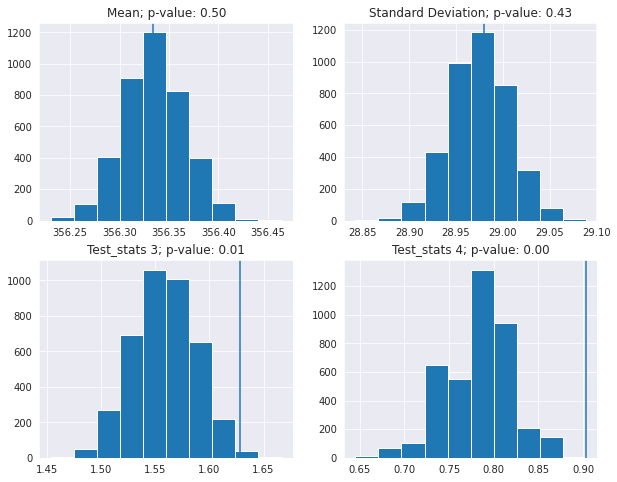

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
predicted_mean = np.mean(quad_y_pred, axis=1)
plt.hist(predicted_mean)
plt.axvline(data.CO2.mean())
plt.title(f'Mean; p-value: {np.mean(data.CO2.mean() < predicted_mean):0.2f}')

plt.subplot(2,2,2)
predicted_std = np.std(quad_y_pred, axis=1)
plt.hist(predicted_std)
plt.axvline(data.CO2.std())
plt.title(f'Standard Deviation; p-value: {np.mean(data.CO2.std() < predicted_std):0.2f}')

plt.subplot(2,2,3)
plt.hist(predicted_stats[:, 0])
plt.axvline(observed_stats[0])
plt.title(f'Test_stats 3; p-value: {np.mean(observed_stats[0] < predicted_stats[:, 0]):0.2f}')
#plt.show()
#print(np.mean(observed_stats[0] > predicted_stats[:, 0]))

plt.subplot(2,2,4)
plt.hist(predicted_stats[:, 1])
plt.axvline(observed_stats[1])
plt.title(f'Test_stats 4; p-value: {np.mean(observed_stats[1] < predicted_stats[:, 1]):0.2f}')

plt.show()
#print(np.mean(observed_stats[1] > predicted_stats[:, 1]))